<img
    style="float:left;width:20%;"
    title="Cardiff University Logo"
    src="https://upload.wikimedia.org/wikipedia/en/b/b1/Cardiff_university_logo.png"
    />

# Media Monitor Analysis

A joint research project between the [School of Computer Science](https://www.cs.cf.ac.uk/) and the [School of Journalism](http://www.cardiff.ac.uk/journalism-media-cultural-studies) at Cardiff University. 

*by [Taylor Rees](http://taylorre.es)*

---

*This notebook requires a mongoDB database called **`media-monitor`** with a **`tweets`** collection containing [Tweet objects](https://dev.twitter.com/overview/api/tweets). It aims to analyse the data collected by the [media-monitor](https://github.com/taylorrees/media-monitor) tool.*

## Table of Contents

- [1. Key Terms](#1.-Key-Terms)


- [2. Getting Started](#2.-Getting-Started)


- [3. Distribution Analysis](#3.-Distribution-Analysis)
    - [3.1. Original Tweets](#3.1.-Original-Tweets)
    - [3.2. Retweets](#3.2.-Retweets)
    - [3.3. Replies](#3.3.-Replies)
    - [3.4. Links](#3.4.-Links)
    - [3.5. Hashtags](#3.5.-Hashtags)
    
    
- [4. Network Analysis](#4.-Network-Analysis)
    - [4.1. Mentions](#4.1.-Mentions)
    - [4.2. Replies](#4.2.-Replies)
    
    
- [5. Sentiment Analysis](#5.-Sentiment-Analysis)
    - [5.1. All Tweets](#5.1.-All-Tweets)
    - [5.2. Journalists](#5.2.-Journalists)
    - [5.3. Organisations](#5.3.-Organisations)

---

## 1. Key Terms

**`JOI`** Journalists of interest

**`OOI`** Organisations of interest

**`EXT`** Accounts not followed by streaming api

## 2. Getting Started

To get started you'll need the following packages
- `pymongo`
- `matplotlib`
- `textblob`
- `beautifulsoup4`

To install them run

In [ ]:
%%bash
pip3 install pymongo
pip3 install matplotlib
pip3 install textblob
pip3 install beautifulsoup4

Next you'll need to import the dependencies. 

In [10]:
"""Import dependencies"""

from collections import Counter
from IPython.display import display
from IPython.display import Markdown
import matplotlib.pyplot as plt
import numpy as np
from db import DB

%matplotlib inline

Collect the tweet data

In [27]:
tweets = [tweet for tweet in DB.tweets.find()]
print(len(tweets))

5000


Now we setup new collections in the database.

We also need to extend the `Collect` class to cater to our needs as we want the store method to clear a specified collection everytime it is called.

_**Note**_

Only call if the journalists and organisations collections are not already setup in the database. This will read the JSON files containing journalist and organisation twitter lists and store them in the appropriate database.

In [ ]:
"""Setup for collection creation"""

from json import load
from collect import Collect

class Collect(Collect):
    def store(self, collection):
        # extend and alter store
        DB[collection].delete_many({})
        DB[collection].insert_many(self.members)

In [ ]:
"""Create database collections"""

# get & store journalists from twitter lists
j = load(open("journalists.json"))
collect = Collect(lists=j)
collect.store("journalists")

# get & store news organisations from twitter lists
o = load(open("organisations.json"))
collect = Collect(lists=o, refine=False, append=True)
collect.store("organisations")

## 3. Distribution Analysis

*A collection of inline visualisations to illustrate the demographics of the data collected.*

In [12]:
"""Setup for distribution analysis"""

journalists = DB.journalists.distinct("id_str")
organisations = DB.organisations.distinct("id_str")

In [13]:
def dist_pie(joi, ooi):
    """Plot a pie chart"""
    
    # calculate mean percentage
    joi_size = len(joi)
    ooi_size = len(ooi)
    total = joi_size + ooi_size

    joi_mean = (joi_size / total) * 100
    ooi_mean = (ooi_size / total) * 100

    # data to plot
    sizes = [joi_mean, ooi_mean]
    labels = "Journalists", "Organisations"
    colors = ['lightskyblue', 'lightcoral']
    
    # plot
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
        shadow=True, startangle=90)

    plt.axis('equal')
    plt.show()

In [14]:
def top_10(joi, ooi, label):
    """Plot a bar chart of top 10"""
    
    # create list of users
    id_strs = ["@%s" % tweet["user"]["screen_name"] 
               for tweet in joi]

    id_strs += ["@%s" % tweet["user"]["screen_name"] 
                for tweet in ooi]

    # count occurances
    counter = Counter(id_strs)
    most_common = counter.most_common(10)

    # data to plot
    labels, y = zip(*most_common)
    x = range(len(labels))
    
    # plot
    plt.bar(x, y, alpha=0.5)
    plt.xticks(x, labels, rotation='90')
    plt.ylabel(label)
    plt.show()

In [15]:
def tabulate(headers, data):
    """Output a markdown table"""
    
    # data to output 
    table = " | ".join(headers) + " \n"
    table += " --- | --- \n"

    for row in data:
        table += " | ".join(str(x) for x in row) + " \n"

    # output
    display(Markdown(table))

### 3.1. Original Tweets

This section of the analysis aims to look at the number of original tweets authored throughout the data collection period. An original tweet is one that has been published by a user that is not a reply nor a retweet. We will look for tweets authored by the `JOI`, `OOI` and `EXT` accounts. 

In [16]:
"""Collect the data"""

# get sets of id_str's

joi_originals = [tweet
                 for tweet in tweets
                     if tweet["user"]["id_str"] in journalists
                     and tweet["in_reply_to_status_id_str"] == None
                     and "retweeted_status" not in tweet]

ooi_originals = [tweet
                 for tweet in tweets
                     if tweet["user"]["id_str"] in organisations
                     and tweet["in_reply_to_status_id_str"] == None
                     and "retweeted_status" not in tweet]

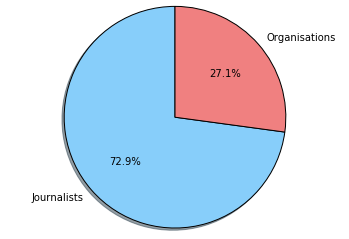

In [17]:
"""Plot a pie chart"""

dist_pie(joi_originals, ooi_originals)

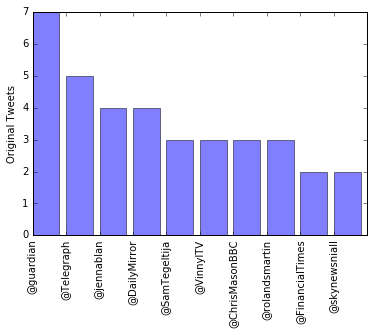

In [18]:
"""Plot top 10"""

top_10(joi_originals, ooi_originals, label="Original Tweets")

### 3.2. Retweets

This section of the analysis aims to look at the number of retweets created throughout the data collection period. 

In [19]:
"""Collect the data"""

# get sets of id_str's

joi_retweets = [tweet
                for tweet in tweets
                    if tweet["user"]["id_str"] in journalists
                    and "retweeted_status" in tweet]

ooi_retweets = [tweet
                for tweet in tweets
                    if tweet["user"]["id_str"] in organisations
                    and "retweeted_status" in tweet]

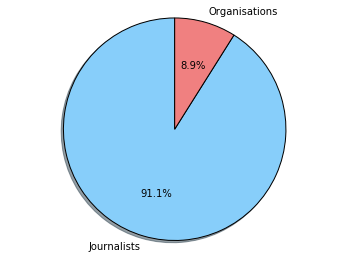

In [20]:
"""Plot a pie chart"""

dist_pie(joi_retweets, ooi_retweets)

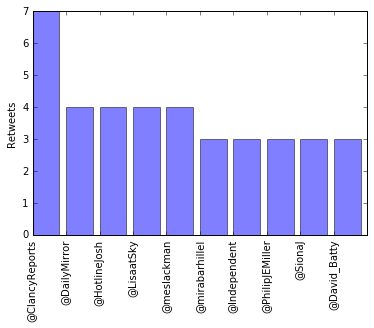

In [21]:
"""Plot top 10"""

top_10(joi_retweets, ooi_retweets, label="Retweets")

### 3.3. Replies

This section of the analysis aims to look at the number of replies authored throughout the data collection period. 

In [22]:
"""Collect the data"""

# get sets of id_str's

joi_replies = [tweet
               for tweet in tweets
                   if tweet["user"]["id_str"] in journalists
                   and tweet["in_reply_to_status_id_str"] != None]

ooi_replies = [tweet
               for tweet in tweets
                   if tweet["user"]["id_str"] in organisations
                   and tweet["in_reply_to_status_id_str"] != None]

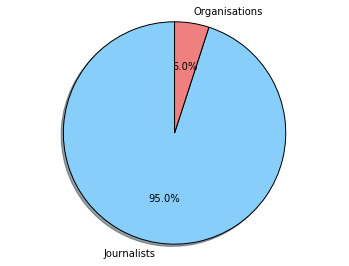

In [23]:
"""Plot a pie chart"""

dist_pie(joi_replies, ooi_replies)

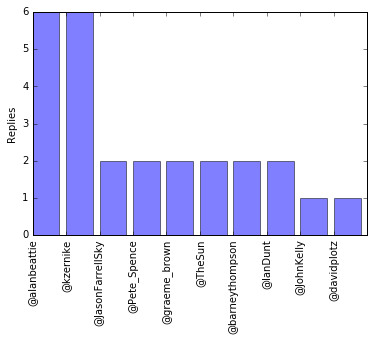

In [24]:
"""Plot top 10"""

top_10(joi_replies, ooi_replies, label="Replies")

### 3.4. Links

This section of the analysis aims to look at the number of links included in the body of the tweets collected throughout the data collection period. 

In [25]:
"""Collect the data"""

urls = [url["expanded_url"] 
        for tweet in tweets 
            for url in tweet["entities"]["urls"]]

In [26]:
"""Display top 10"""

import requests
import bs4
import re

def get_title(url):
    """Get some article contect i.e. title of 
    article, subtitle, etc."""
    
    # get title text
    html = requests.get(url)
    soup = bs4.BeautifulSoup(html.text, "html.parser")
    title = soup.title.string
    # remove markdown grammar
    title = re.sub(r"\r", " ", title)
    title = re.sub(r"\n", " ", title)
    title = re.sub(r"\|", " ", title)
    title = re.sub(r"\s+", " ", title)
    # remove leading whitespace
    title = title.lstrip()
    # remove trailing whitespace
    title = title.rstrip()
    
    return title

counter = Counter(urls)
most_common_links = [(url, get_title(url), occ) 
                     for (url, occ) in counter.most_common(10)]

tabulate(["URL", "Page Title", "Occurances"], most_common_links)

URL | Page Title | Occurances 
 --- | --- 
http://bbc.co.uk/chilcot | The Chilcot report - BBC News | 586 
http://snpy.tv/29w8hdD | BBC Breaking News on Twitter: "Tony Blair is "world's worst terrorist" - sister of serviceman killed in Iraq. #Chilcot https://t.co/lOjx5zJlK8 https://t.co/ulg7lJYCu2" | 173 
http://bbc.in/29lj1LX | Lionel Messi handed jail term in Spain for tax fraud - BBC News | 146 
http://cnn.it/29gUodd | Lionel Messi: Soccer star handed 21-month prison sentence - CNN.com | 70 
http://reut.rs/29lj4HT | Inquiry slams ex-PM Blair for catalogue of failures over Iraq war Reuters | 60 
http://www.telegraph.co.uk/news/2016/07/06/chilcot-inquiry-judgement-day-for-tony-blair-as-iraq-war-report/ | Chilcot report: Tony Blair takes 'full responsibility' for Iraq war as Jeremy Corbyn 'apologises sincerely on behalf' of Labour party | 58 
http://bbc.in/29l5lRm | Africa highlights: Wednesday 6 July 2016, as it happened - BBC News | 45 
http://snpy.tv/29hfPeJ | BBC Breaking News on Twitter: "The moment #OscarPistorius hears his 6-year murder sentence - and the court's reaction https://t.co/o5GqkpHpe7 https://t.co/KQ68JaQAi0" | 44 
http://ind.pn/29nxzqs | Chilcot Report: Bereaved families say Tony Blair is ‘the world's worst terrorist’ and we want to see him in court UK Politics News The Independent | 42 
http://nyti.ms/29w2dli | Clinton Case in Context: When Politics and Prosecutions Overlap - The New York Times | 40 


In [28]:
"""Display an overview"""

tabulate(("Links", "Unique"), [(len(urls), len(set(urls)))])

Links | Unique 
 --- | --- 
3195 | 657 


### 3.5. Hashtags

This section of the analysis aims to look at the number of hashtags included in the body of the tweets collected throughout the data collection period. 

In [29]:
"""Collect the data"""

hashtags = [hashtags["text"] 
            for tweet in tweets 
            for hashtags in tweet["entities"]["hashtags"]]

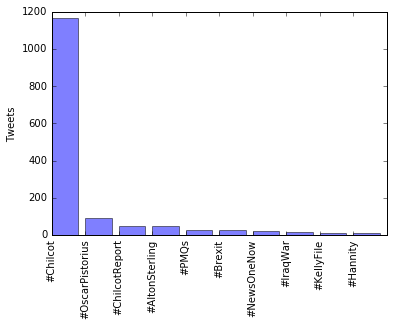

In [33]:
"""Plot top 10"""

most_common = Counter(hashtags).most_common(10)
most_common = [("#" + key, value) for (key, value) in most_common]

# data to plot
labels, y = zip(*most_common)
x = range(len(labels))
    
# plot
plt.bar(x, y, alpha=0.5)
plt.xticks(x, labels, rotation='90')
plt.ylabel("Tweets")
plt.show()

In [34]:
# FUTURE
# Group journalists by hashtag and determine their discussions
# Can guage how much work is discused / How personal the account is

In [35]:
"""Display an overview"""

tabulate(("Hashtags", "Unique"), [(len(hashtags), len(set(hashtags)))])

Hashtags | Unique 
 --- | --- 
1735 | 167 


## 4. Network Analysis

*A collection of computed datasets to create network visualisations using an external graphing tool such as [Gephi](https://gephi.org).*

In [3]:
"""Setup for network analysis"""

from pymongo import MongoClient
from csv import writer
from time import time

# specify output folder
output_folder = "./analysis"

### 4.1. Mentions

This section aims to generate a collection of nodes and associated edges from a twitter mentions dataset. 

In [4]:
"""Collect the data"""

start = time()

# find all edges
edges = [(tweet["user"]["screen_name"], mention["screen_name"])
         for tweet in tweets[:]
             for mention in tweet["entities"]["user_mentions"]]

# generate nodes from edges
nodes = {node 
         for edge in edges 
             for node in edge}

print("Runtime: %.3fs" % (time() - start))

Runtime: 0.015s


In [5]:
"""Write nodes to CSV"""

node_file = "%s/mention_nodes.csv" % (output_folder)

# convert into csv format
nodes = [[node, node] 
         for node in nodes]

with open(node_file, 'w') as f:
    w = writer(f)
    w.writerow(["id", "label"])
    w.writerows(nodes)

In [6]:
"""Write edges to CSV"""

edge_file = "%s/mention_edges.csv" % (output_folder)

# convert into csv format
edges = [[nodes[0], nodes[1], weight] 
         for nodes, weight in Counter(edges).items()]

with open(edge_file, 'w') as f:
    w = writer(f)
    w.writerow(["source", "target", "weight"])
    w.writerows(edges)

### 4.2. Replies

This section aims to generate a collection of nodes and associated edges from a twitter replies dataset. 

In [ ]:
"""Collect the data"""

start = time()
nodes = set()
edges = set()

# collect nodes
for tweet in tweets:
    source = tweet["user"]["id_str"]
    target = tweet["in_reply_to_user_id_str"]

    if target is not None:
        nodes.add((source, source))
        nodes.add((target, target))
        edges.add((source, target))
        
print("Runtime: %.3fs" % (time() - start))

In [ ]:
"""Write nodes to CSV"""

node_file = "%s/reply_nodes.csv" % (output_folder)

with open(node_file, 'w') as f:
    w = writer(f)
    w.writerow(["id", "label"])
    w.writerows(nodes)

In [ ]:
"""Write edges to CSV"""

edge_file = "%s/reply_edges.csv" % (output_folder)

with open(edge_file, 'w') as f:
    w = writer(f)
    w.writerow(["source", "target"])
    w.writerows(edges)

## 5. Sentiment Analysis

*An attempt to classify the sentiment of the collected data.*

In [62]:
"""Setup for sentiment analysis"""

from textblob import TextBlob

In [63]:
def sentiment(tweets):
    """Get the number of positive, neutral and
    negative tweets in a sample."""
    
    polarity = [TextBlob(tweet["text"]).sentiment.polarity
                for tweet in tweets]

    positive = len([x 
                    for x in polarity
                         if x > 0])

    neutral = len([x 
                  for x in polarity
                      if x == 0])

    negative = len([x 
                   for x in polarity
                       if x < 0])
    
    return positive, neutral, negative

In [64]:
def sent_pie(positive, neutral, negative):
    """Plot a pie chart"""
    
    sizes = (negative, neutral, positive)
    labels = ("Negative", "Neutral", "Positive")
    colors = ('lightcoral', 'gold', 'lightgreen')

    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
            shadow=True, startangle=90, explode=(0,0,0.1))

    plt.axis('equal')
    plt.show()

### 5.1. All Tweets

This section aims to produce statistics related to the sentiment of all tweets in the dataset.

In [65]:
"""Collect the data"""

positive, neutral, negative = sentiment(tweets=tweets)

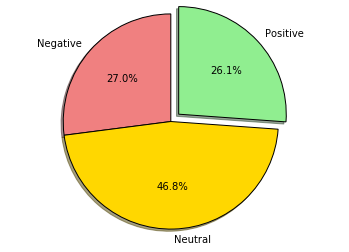

In [66]:
"""Plot a pie chart"""

sent_pie(positive, neutral, negative)

### 5.2. Journalists

This section aims to produce statistics related to the sentiment of all original tweets authored by the journalists in the dataset. Please run the first cell of [section 3.1.](#3.1.-Original-Tweets) before attempting to run this section as it requires the `joi_originals` dataset in order to function as intended.

In [67]:
"""Collect the data"""

positive, neutral, negative = sentiment(joi_originals)

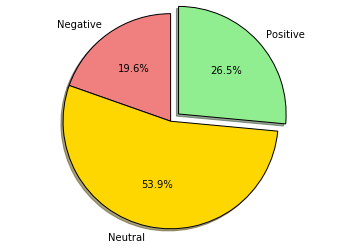

In [68]:
"""Plot a pie chart"""

sent_pie(positive, neutral, negative)

### 5.3. Organisations

This section aims to produce statistics related to the sentiment of all original tweets authored by the organisations in the dataset. Please run the first cell of [section 3.1.](#3.1.-Original-Tweets) before attempting to run this section as it requires the `ooi_originals` dataset in order to function as intended.

In [69]:
"""Collect the data"""

positive, neutral, negative = sentiment(ooi_originals)

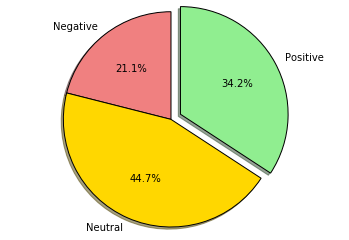

In [70]:
"""Plot a pie chart"""

sent_pie(positive, neutral, negative)